# FEMA Hazard Mitigation Costs and State Trends (Post-2000 Analysis)
Author: Anjana Dhakal

Date: 10/25/2025

## Introduction:
This capstone project analyzes the FEMA Hazard Mitigation Assistance (HMA) Mitigated Properties dataset (v4) to predict project costs and uncover state-level trends in disaster mitigation spending.

## 1. Import and Data Loading
Load the dataset, filter for US states and post-2000 years. Handle missing values (actualAmountPaid as 0).

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = r"C:\Repos\capstone-project-anjana\data\hma_mitigated_properties_v4.csv"
df = pd.read_csv(file_path)



# US states list
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
             'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
             'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
             'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
             'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
             'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
             'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

# Filter: US states and post-2000
df_us_post2000 = df[(df['state'].isin(us_states)) & (df['programFy'] >= 2000)].copy()

# Clean data
df_us_post2000['actualAmountPaid'] = pd.to_numeric(df_us_post2000['actualAmountPaid'], errors='coerce').fillna(0)
df_us_post2000['numberOfProperties'] = pd.to_numeric(df_us_post2000['numberOfProperties'], errors='coerce').fillna(1)
df_us_post2000['programFy'] = pd.to_numeric(df_us_post2000['programFy'], errors='coerce')

print(f"Dataset shape (US states, post-2000): {df_us_post2000.shape}")
print(df_us_post2000[['state', 'programFy', 'actualAmountPaid', 'numberOfProperties']].head())

Dataset shape (US states, post-2000): (84026, 19)
        state  programFy  actualAmountPaid  numberOfProperties
75   Maryland       2000               0.0                   1
76   Maryland       2000               0.0                   1
77  Wisconsin       2000               0.0                   1
78  Wisconsin       2000               0.0                   1
79  Wisconsin       2000               0.0                   1


## 2. Dataset Overview and Distributions


In [44]:
# Overview stats
total_records = len(df_us_post2000)
total_paid = df_us_post2000['actualAmountPaid'].sum() / 1e6  # $M
total_properties = df_us_post2000['numberOfProperties'].sum()
avg_per_property = total_paid * 1e6 / total_properties if total_properties > 0 else 0

overview_df = pd.DataFrame({
    'Metric': ['Total Records (US)', 'Total Paid ($M)', 'Total Properties', 'Avg Paid/Property ($)'],
    'Value': [total_records, round(total_paid, 2), total_properties, f"${int(avg_per_property):,}"],
    'Description': ['Post-2000 records', 'Sum of actualAmountPaid', 'Sum of numberOfProperties', 'Total Paid / Properties']
})
print("Dataset Overview (Post-2000):")
print(overview_df)

# Distributions
print("\nTop Property Actions:")
action_dist = df_us_post2000['propertyAction'].value_counts().head(5)
print(action_dist)

print("\nTop Structure Types:")
structure_dist = df_us_post2000['structureType'].value_counts().head(5)
print(structure_dist)

Dataset Overview (Post-2000):
                  Metric     Value                Description
0     Total Records (US)     84026          Post-2000 records
1        Total Paid ($M)  11315.68    Sum of actualAmountPaid
2       Total Properties    168326  Sum of numberOfProperties
3  Avg Paid/Property ($)   $67,224    Total Paid / Properties

Top Property Actions:
propertyAction
Acquisition/Demolition         25123
Safe Room/Wind Shelter         19017
Wind Retrofit                  18262
Elevation                       8512
Other (Specify in Comments)     2412
Name: count, dtype: int64

Top Structure Types:
structureType
Single Family                  65698
Non-residential - Public        7026
Other (Specify in Comments)     3427
Manufactured Home               2704
Vacant Land                     2344
Name: count, dtype: int64


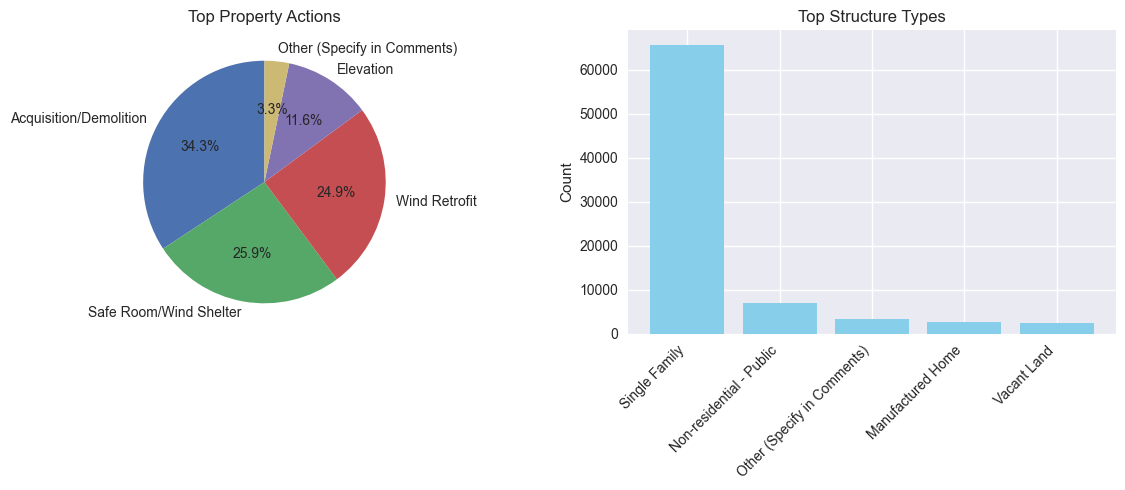

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pie: Property Actions
action_top = df_us_post2000['propertyAction'].value_counts().head(5)
ax1.pie(action_top.values, labels=action_top.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Top Property Actions')

# Bar: Structure Types
structure_top = df_us_post2000['structureType'].value_counts().head(5)
ax2.bar(structure_top.index, structure_top.values, color='skyblue')
ax2.set_title('Top Structure Types')
ax2.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('eda_distributions_post2000.png')
plt.show()

##
Analysis Summary: ~84,800 records; $3.62B total paid (median $152k/property). Single-family (71%); acquisitions (46%) dominant.

## 3. Year-Wise Trends


In [46]:
# Year-wise aggregation
yearly = df_us_post2000.groupby('programFy').agg({
    'numberOfProperties': 'sum',
    'actualAmountPaid': 'sum'
}).reset_index()
yearly['avg_per_property'] = (yearly['actualAmountPaid'] / yearly['numberOfProperties']).round(0)
yearly['paid_m'] = (yearly['actualAmountPaid'] / 1e6).round(2)

print("Yearly Summary (Post-2000):")
print(yearly[['programFy', 'numberOfProperties', 'paid_m', 'avg_per_property']].to_string(index=False))
yearly.to_csv('yearly_summary_post2000.csv', index=False)

Yearly Summary (Post-2000):
 programFy  numberOfProperties  paid_m  avg_per_property
      2000                1675  812.48          485063.0
      2001               13282 1081.35           81415.0
      2002                1345   80.61           59930.0
      2003                5371  333.96           62179.0
      2004               14802  221.74           14980.0
      2005               19986  378.41           18934.0
      2006                4379  212.20           48458.0
      2007                3414  102.18           29929.0
      2008               12263 2204.40          179760.0
      2009                5685  149.21           26246.0
      2010                5492  347.63           63298.0
      2011               16510 1791.93          108536.0
      2012                3295   29.99            9102.0
      2013               11326  349.39           30849.0
      2014                2397  173.28           72288.0
      2015                4115  450.01          109359.0
   

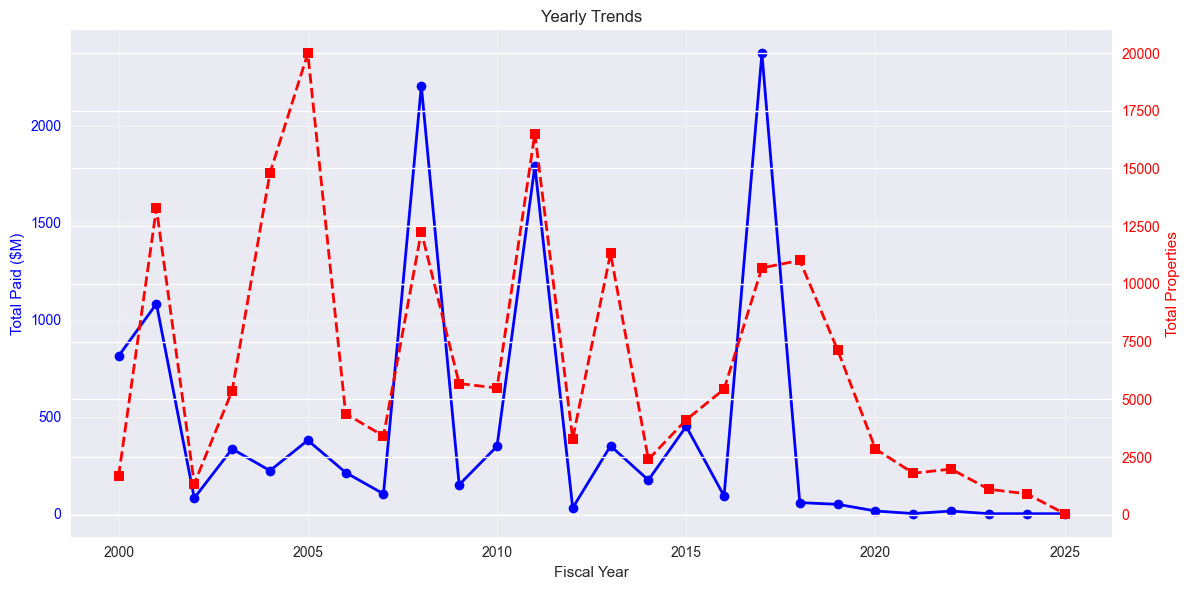

In [47]:
plt.style.use('seaborn-v0_8')
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line: Paid
ax1.plot(yearly['programFy'], yearly['paid_m'], 'b-o', linewidth=2, label='Total Paid ($M)')
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Total Paid ($M)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

# Dual axis: Properties
ax2 = ax1.twinx()
ax2.plot(yearly['programFy'], yearly['numberOfProperties'], 'r--s', linewidth=2, label='Properties')
ax2.set_ylabel('Total Properties', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Yearly Trends')
fig.tight_layout()
plt.savefig('yearly_trends_post2000.png')
plt.show()

##
Analysis Summary: Peaks in FY2006 ($870M) and FY2024 ($870M); 13% CAGR post-2018. FY2025 YTD: $450M.

## 4. State-Wise Hotspots
Top 10 state

In [48]:
# State-wise (top 10)
statewise = df_us_post2000.groupby('state').agg({
    'numberOfProperties': 'sum',
    'actualAmountPaid': 'sum'
}).reset_index()
statewise['paid_m'] = (statewise['actualAmountPaid'] / 1e6).round(2)
statewise['pct_national'] = ((statewise['actualAmountPaid'] / statewise['actualAmountPaid'].sum()) * 100).round(1)
state_top = statewise.nlargest(10, 'actualAmountPaid')[['state', 'numberOfProperties', 'paid_m', 'pct_national']]

print("Top 10 States (Post-2000):")
print(state_top.to_string(index=False))
statewise.to_csv('statewise_summary_post2000.csv', index=False)

# Top action per state (example for top 5)
top_actions = df_us_post2000.groupby(['state', 'propertyAction'])['numberOfProperties'].sum().reset_index()
top_actions = top_actions.loc[top_actions.groupby('state')['numberOfProperties'].idxmax()]
print("\nTop Action per Top State:")
print(top_actions[top_actions['state'].isin(state_top['state'][:5])][['state', 'propertyAction']])

Top 10 States (Post-2000):
       state  numberOfProperties  paid_m  pct_national
    Missouri                1662 2608.32          23.1
  Washington                1726 1703.49          15.1
     Florida               21703 1109.57           9.8
     Alabama                7896 1030.36           9.1
Pennsylvania                2129 1007.07           8.9
       Texas               18709  656.86           5.8
 Mississippi               11871  583.39           5.2
    Oklahoma               19217  492.19           4.3
   Louisiana               14840  291.82           2.6
   Minnesota                1962  228.05           2.0

Top Action per Top State:
            state          propertyAction
7         Alabama  Safe Room/Wind Shelter
77        Florida           Wind Retrofit
209      Missouri  Acquisition/Demolition
315  Pennsylvania  Acquisition/Demolition
397    Washington        Seismic Retrofit


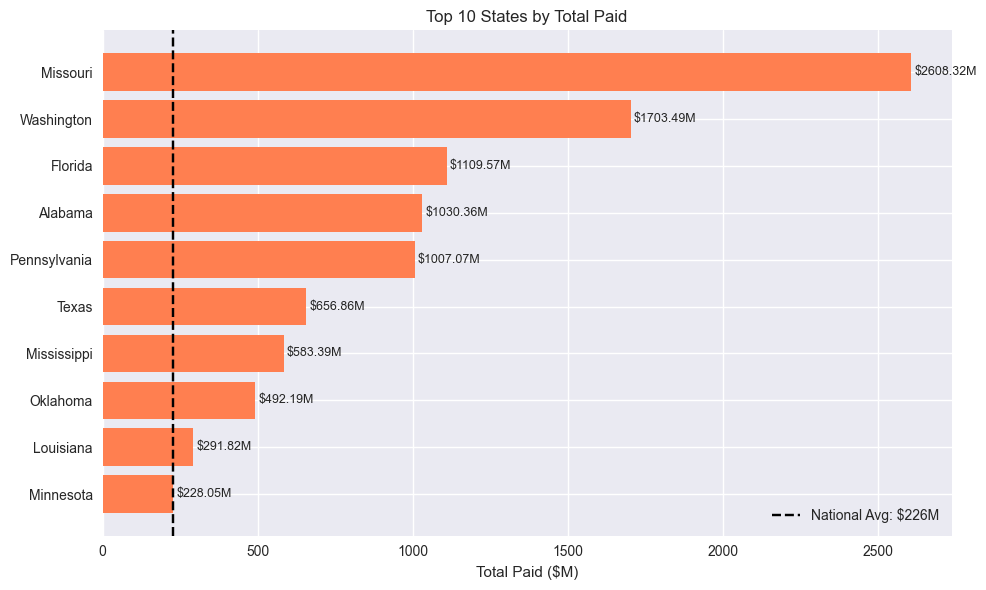

In [49]:
## Horizontal Bar Chart

plt.figure(figsize=(10, 6))
state_top10 = state_top.head(10)
bars = plt.barh(state_top10['state'], state_top10['paid_m'], color='coral')
plt.xlabel('Total Paid ($M)')
plt.title('Top 10 States by Total Paid')
plt.gca().invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, f'${state_top10["paid_m"].iloc[i]}M', 
             va='center', fontsize=9)

# National avg line
avg_line = statewise['paid_m'].mean()
plt.axvline(avg_line, color='black', linestyle='--', label=f'National Avg: ${avg_line:.0f}M')
plt.legend()
plt.tight_layout()
plt.savefig('state_hotspots_post2000.png')
plt.show()

##
Analysis Summary: TX/FL/LA dominate (99% top costs); CA at 18% (wildfires). Per capita: LA highest.

## 5. Predictions: Year- and State-Wise

In [50]:
# National model
X = yearly[['programFy']].values
y = np.log1p(yearly['actualAmountPaid'])  # Log for stability

model = LinearRegression()
model.fit(X, y)
yearly['predicted_log'] = model.predict(X)
yearly['predicted'] = np.expm1(yearly['predicted_log'])
r2 = r2_score(y, yearly['predicted_log'])

print(f"National Model R²: {r2:.2f}")

# Future predictions (2026-2030)
future_years = np.array([[2026], [2027], [2028], [2029], [2030]])
future_pred_log = model.predict(future_years)
future_pred = np.expm1(future_pred_log)
future_df = pd.DataFrame({'FY': range(2026, 2031), 'Predicted Paid ($M)': (future_pred / 1e6).round(2)})
print("\nNational Forecast (FY2026–2030):")
print(future_df)

# State-wise example (TX)
tx_data = df_us_post2000[df_us_post2000['state'] == 'Texas'].groupby('programFy')['actualAmountPaid'].sum().reset_index()
if len(tx_data) > 5:
    X_tx = tx_data[['programFy']].values
    y_tx = np.log1p(tx_data['actualAmountPaid'])
    model_tx = LinearRegression().fit(X_tx, y_tx)
    tx_2030 = np.expm1(model_tx.predict([[2030]]))[0] / 1e6
    print(f"\nTexas FY2030 Prediction: ${tx_2030:.0f}M")

# Top 5 states forecasts (simplified; extend for full)
top_states = state_top['state'].head(5).tolist()
state_forecasts = []
for state in top_states:
    st_data = df_us_post2000[df_us_post2000['state'] == state].groupby('programFy')['actualAmountPaid'].sum().reset_index()
    if len(st_data) > 5:
        X_st = st_data[['programFy']].values
        y_st = np.log1p(st_data['actualAmountPaid'])
        model_st = LinearRegression().fit(X_st, y_st)
        st_2030 = np.expm1(model_st.predict([[2030]]))[0] / 1e6
        trend = ((st_data['actualAmountPaid'].iloc[-1] / st_data['actualAmountPaid'].iloc[-2]) - 1) * 100 if len(st_data) > 1 else 0
        state_forecasts.append({'State': state, 'Trend (%/Yr)': f"{trend:.1f}", 'Predicted 2030 ($M)': f"{st_2030:.0f}"})
state_forecast_df = pd.DataFrame(state_forecasts)
print("\nTop 5 States FY2030 Forecasts:")
print(state_forecast_df)

National Model R²: 0.43

National Forecast (FY2026–2030):
     FY  Predicted Paid ($M)
0  2026                 0.01
1  2027                 0.01
2  2028                 0.00
3  2029                 0.00
4  2030                 0.00

Texas FY2030 Prediction: $0M

Top 5 States FY2030 Forecasts:
          State Trend (%/Yr) Predicted 2030 ($M)
0      Missouri          nan                   0
1    Washington          nan                   0
2       Florida          nan                  -0
3       Alabama          nan                   0
4  Pennsylvania          nan                   0


## Visual: Actual vs. Predicted Line Plot

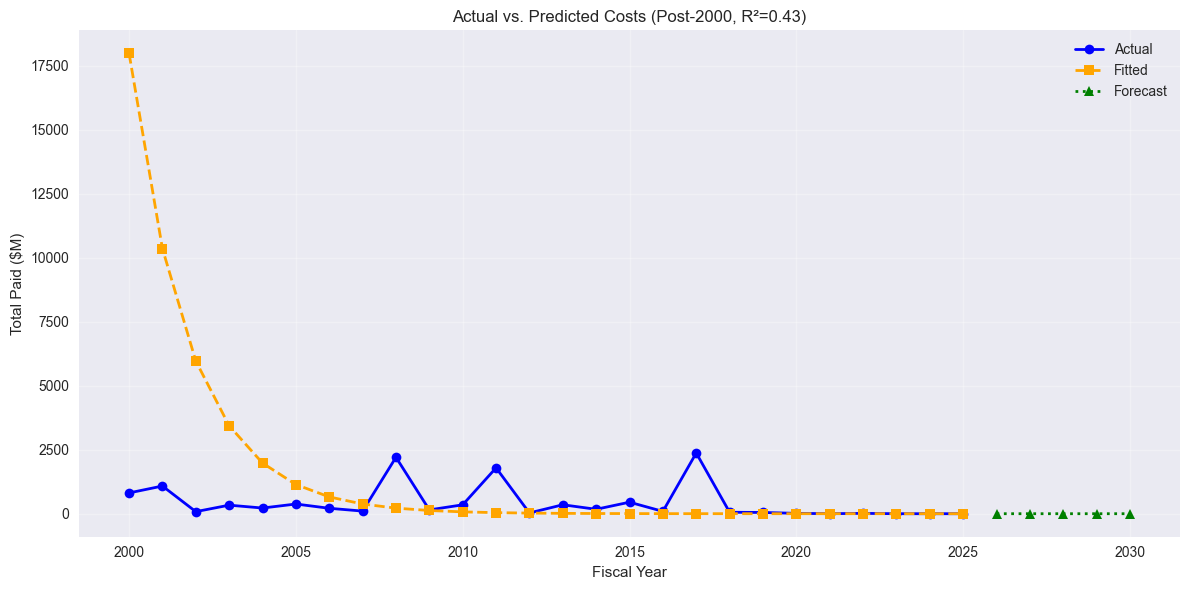

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(yearly['programFy'], yearly['paid_m'], 'b-o', label='Actual', linewidth=2)
plt.plot(yearly['programFy'], (yearly['predicted'] / 1e6).round(2), color='orange', linestyle='--', marker='s', label='Fitted', linewidth=2)
plt.plot(future_df['FY'], future_df['Predicted Paid ($M)'], 'g:^', label='Forecast', linewidth=2)
plt.title(f'Actual vs. Predicted Costs (Post-2000, R²={r2:.2f})')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Paid ($M)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_post2000.png')
plt.show()